# Прогноз урожайности зерновых по спутниковым данным и метеоинформации

## Описание задачи
- **Задача**: Регрессия — предсказание урожайности (ц/га) по временным рядам
- **Модели**: LSTM, Transformer, CNN-LSTM
- **Данные**: Спутниковые индексы (NDVI, EVI) + метеоданные (температура, осадки, солнечная радиация)
- **Регионы**: Краснодарский край, Ростовская область, Ставропольский край, Саратовская область, Алтайский край
- **Период**: 2010-2023 гг.

## 1. Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


## 2. Загрузка и анализ данных

In [3]:
# Загрузка данных
data_path = '../data/raw/russia_crop_yield_dataset_2010_2023.csv'
df = pd.read_csv(data_path)

# Основная информация о данных
print("Форма датасета:", df.shape)
print("\nКолонки:", df.columns.tolist())
print("\nТипы данных:")
print(df.dtypes)
print("\nПропущенные значения:")
print(df.isnull().sum())
print("\nПервые 5 строк:")
df.head()

Форма датасета: (840, 9)

Колонки: ['region', 'year', 'month', 'NDVI', 'EVI', 'T2M_mean', 'PRECTOT_mm', 'SOLAR_RAD_MJ', 'yield_centners_per_ha']

Типы данных:
region                       str
year                       int64
month                      int64
NDVI                     float64
EVI                      float64
T2M_mean                 float64
PRECTOT_mm               float64
SOLAR_RAD_MJ             float64
yield_centners_per_ha    float64
dtype: object

Пропущенные значения:
region                   0
year                     0
month                    0
NDVI                     0
EVI                      0
T2M_mean                 0
PRECTOT_mm               0
SOLAR_RAD_MJ             0
yield_centners_per_ha    0
dtype: int64

Первые 5 строк:


,region,year,month,NDVI,EVI,T2M_mean,PRECTOT_mm,SOLAR_RAD_MJ,yield_centners_per_ha
0,Krasnodar Krai,2010,1,0.215,0.178,-3.92,20.38,5.47,37.20
1,Krasnodar Krai,2010,2,0.205,0.145,-7.74,32.83,8.31,37.00
2,Krasnodar Krai,2010,3,0.222,0.169,0.85,32.75,8.13,37.34
3,Krasnodar Krai,2010,4,0.343,0.287,13.31,48.78,14.57,39.77
4,Krasnodar Krai,2010,5,0.488,0.378,15.92,57.65,18.70,42.66


In [4]:
# Статистическое описание данных
print("Статистическое описание числовых признаков:")
df.describe()

Статистическое описание числовых признаков:


,year,month,NDVI,EVI,T2M_mean,PRECTOT_mm,SOLAR_RAD_MJ,yield_centners_per_ha
count,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,2016.500000,6.500000,0.409299,0.327707,7.851964,38.593667,15.105143,39.340524
std,4.033531,3.454109,0.177399,0.143533,8.958069,14.579416,6.644658,7.900594
min,2010.000000,1.000000,0.142000,0.090000,-10.340000,8.450000,3.690000,23.140000
25%,2013.000000,3.750000,0.246000,0.199750,-0.030000,26.010000,8.935000,32.915000
50%,2016.500000,6.500000,0.367500,0.292000,8.190000,36.580000,14.485000,39.090000
75%,2020.000000,9.250000,0.577250,0.456750,16.172500,51.592500,20.915000,45.420000
max,2023.000000,12.000000,0.767000,0.629000,24.750000,70.090000,27.330000,58.810000


In [5]:
# Анализ регионов
print("Уникальные регионы:")
regions = df['region'].unique()
print(regions)
print(f"\nКоличество регионов: {len(regions)}")

# Количество записей по регионам
print("\nКоличество записей по регионам:")
df['region'].value_counts()

Уникальные регионы:
<StringArray>
['Krasnodar Krai',  'Rostov Oblast', 'Stavropol Krai', 'Saratov Oblast',
     'Altai Krai']
Length: 5, dtype: str

Количество регионов: 5

Количество записей по регионам:


region
Krasnodar Krai    168
Rostov Oblast     168
Stavropol Krai    168
Saratov Oblast    168
Altai Krai        168
Name: count, dtype: int64

## 3. Визуализация данных

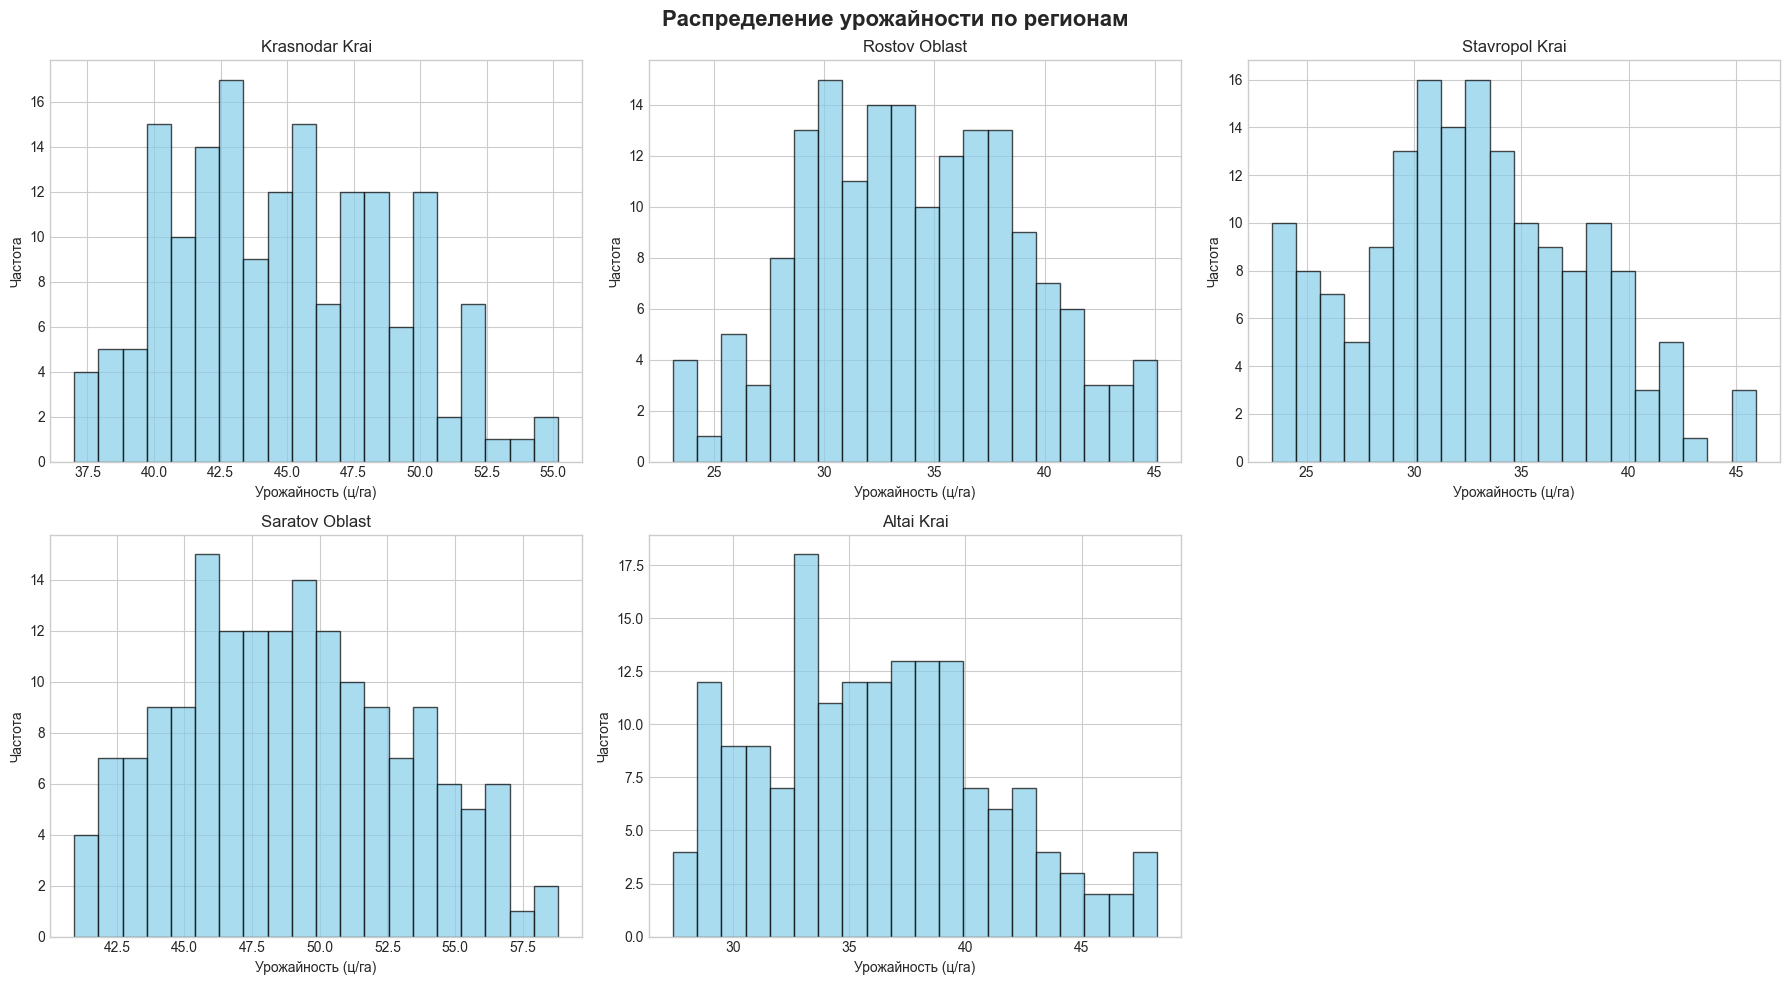

In [6]:
# Визуализация распределения урожайности по регионам
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, region in enumerate(regions):
    region_data = df[df['region'] == region]
    axes[i].hist(region_data['yield_centners_per_ha'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('Урожайность (ц/га)')
    axes[i].set_ylabel('Частота')

# Удаляем лишний subplot
axes[-1].remove()

plt.suptitle('Распределение урожайности по регионам', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

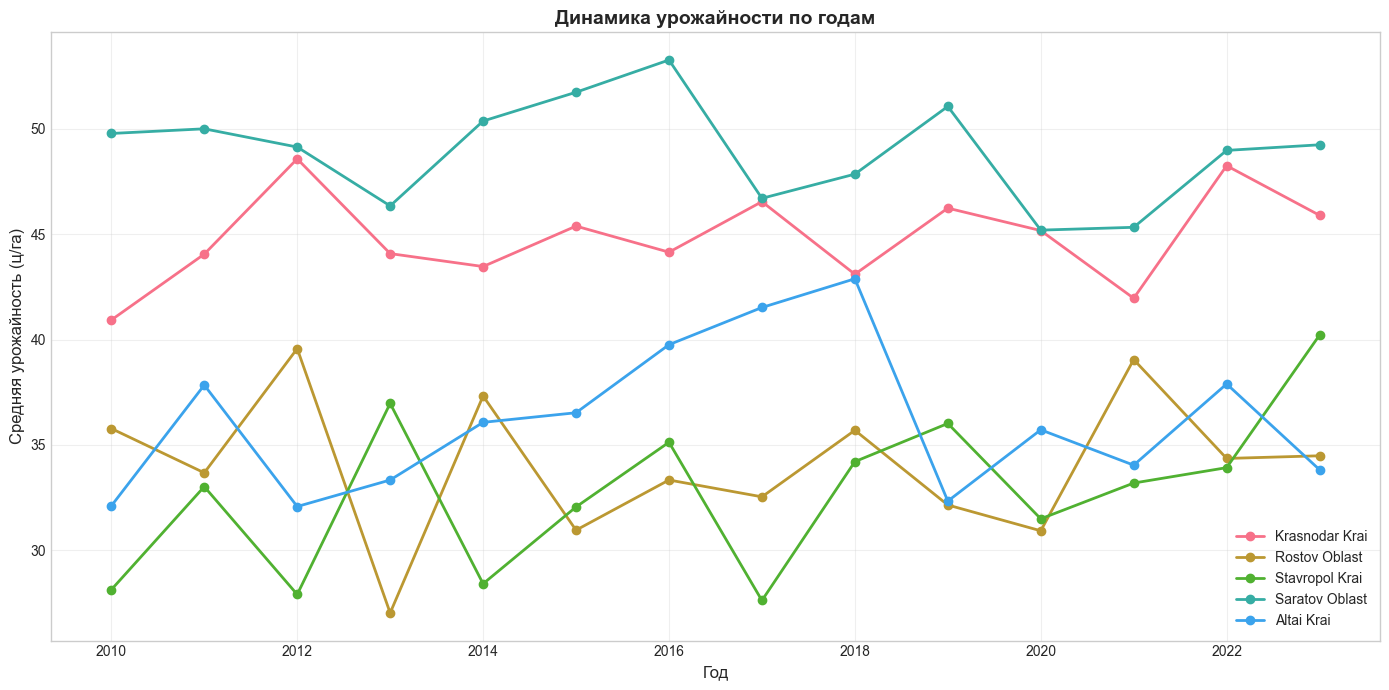

In [7]:
# Динамика урожайности по годам для каждого региона
fig, ax = plt.subplots(figsize=(14, 7))

for region in regions:
    region_data = df[df['region'] == region]
    yearly_yield = region_data.groupby('year')['yield_centners_per_ha'].mean()
    ax.plot(yearly_yield.index, yearly_yield.values, marker='o', linewidth=2, label=region)

ax.set_xlabel('Год', fontsize=12)
ax.set_ylabel('Средняя урожайность (ц/га)', fontsize=12)
ax.set_title('Динамика урожайности по годам', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

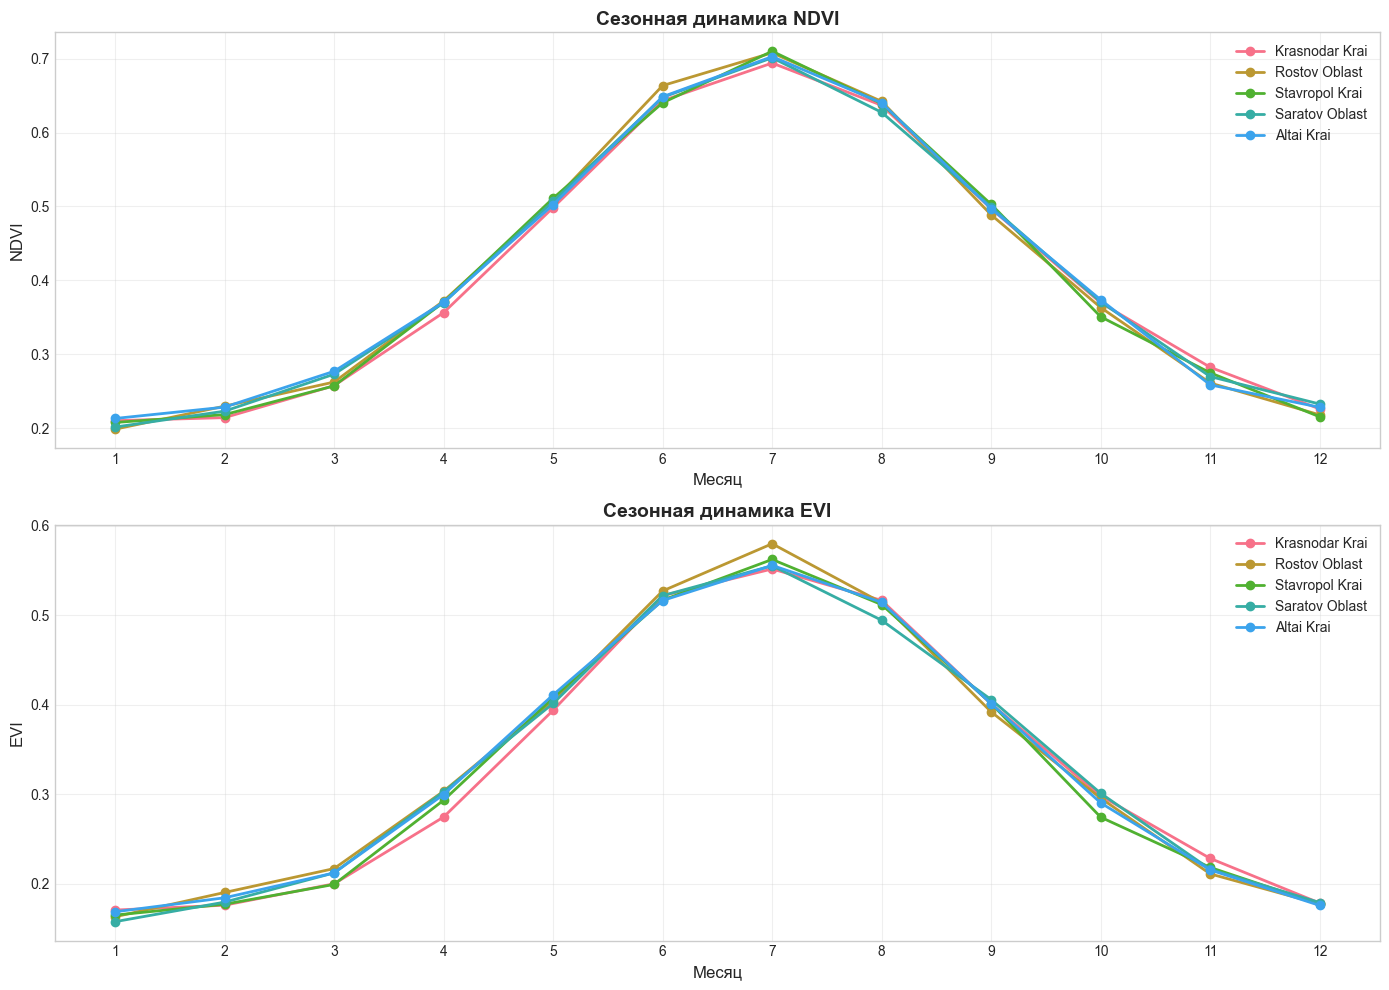

In [8]:
# Сезонная динамика NDVI и EVI
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# NDVI по месяцам
for region in regions:
    region_data = df[df['region'] == region]
    monthly_ndvi = region_data.groupby('month')['NDVI'].mean()
    axes[0].plot(monthly_ndvi.index, monthly_ndvi.values, marker='o', linewidth=2, label=region)

axes[0].set_xlabel('Месяц', fontsize=12)
axes[0].set_ylabel('NDVI', fontsize=12)
axes[0].set_title('Сезонная динамика NDVI', fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, 13))

# EVI по месяцам
for region in regions:
    region_data = df[df['region'] == region]
    monthly_evi = region_data.groupby('month')['EVI'].mean()
    axes[1].plot(monthly_evi.index, monthly_evi.values, marker='o', linewidth=2, label=region)

axes[1].set_xlabel('Месяц', fontsize=12)
axes[1].set_ylabel('EVI', fontsize=12)
axes[1].set_title('Сезонная динамика EVI', fontsize=14, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

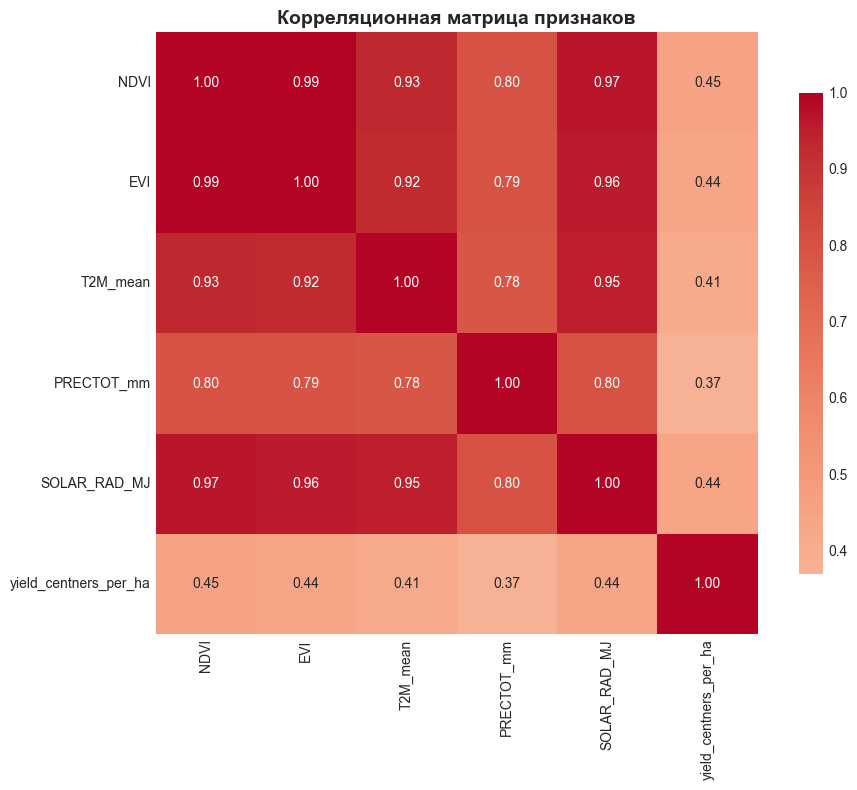

In [9]:
# Корреляционная матрица
numeric_cols = ['NDVI', 'EVI', 'T2M_mean', 'PRECTOT_mm', 'SOLAR_RAD_MJ', 'yield_centners_per_ha']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Корреляционная матрица признаков', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Предобработка данных

In [10]:
# Кодирование регионов
region_mapping = {region: idx for idx, region in enumerate(regions)}
df['region_encoded'] = df['region'].map(region_mapping)

print("Кодирование регионов:")
for region, code in region_mapping.items():
    print(f"{region}: {code}")

Кодирование регионов:
Krasnodar Krai: 0
Rostov Oblast: 1
Stavropol Krai: 2
Saratov Oblast: 3
Altai Krai: 4


In [11]:
# Подготовка признаков
feature_cols = ['NDVI', 'EVI', 'T2M_mean', 'PRECTOT_mm', 'SOLAR_RAD_MJ', 'region_encoded']
target_col = 'yield_centners_per_ha'

X = df[feature_cols].values
y = df[target_col].values

print(f"Размерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")

Размерность признаков: (840, 6)
Размерность целевой переменной: (840,)


In [12]:
# Нормализация данных
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

print("Нормализация выполнена")
print(f"Признаки - Mean: {X_scaled.mean(axis=0).round(4)}, Std: {X_scaled.std(axis=0).round(4)}")
print(f"Целевая переменная - Min: {y_scaled.min():.4f}, Max: {y_scaled.max():.4f}")

Нормализация выполнена
Признаки - Mean: [-0. -0.  0.  0.  0.  0.], Std: [1. 1. 1. 1. 1. 1.]
Целевая переменная - Min: 0.0000, Max: 1.0000


In [13]:
# Создание временных последовательностей
def create_sequences(data, target, sequence_length=12):
    """
    Создание последовательностей для временных рядов
    """
    X_seq, y_seq = [], []
    for i in range(len(data) - sequence_length):
        X_seq.append(data[i:(i + sequence_length)])
        y_seq.append(target[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

SEQUENCE_LENGTH = 12  # 12 месяцев

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQUENCE_LENGTH)

print(f"Размерность последовательностей X: {X_seq.shape}")
print(f"Размерность целевой переменной y: {y_seq.shape}")

Размерность последовательностей X: (828, 12, 6)
Размерность целевой переменной y: (828,)


In [14]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (662, 12, 6), (662,)
Test set: (166, 12, 6), (166,)


## 5. Определение моделей

In [15]:
# LSTM Model
def build_lstm_model(sequence_length, n_features):
    model = keras.Sequential([
        keras.layers.LSTM(128, return_sequences=True, 
                         input_shape=(sequence_length, n_features)),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(64, return_sequences=False),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

In [16]:
# CNN-LSTM Model
def build_cnn_lstm_model(sequence_length, n_features):
    model = keras.Sequential([
        keras.layers.Conv1D(64, 3, activation='relu', padding='same',
                           input_shape=(sequence_length, n_features)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling1D(2),
        keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling1D(2),
        keras.layers.LSTM(64, return_sequences=False),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

In [17]:
# Transformer Block
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential([
            keras.layers.Dense(ff_dim, activation='relu'),
            keras.layers.Dense(embed_dim)
        ])
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(dropout_rate)
        self.dropout2 = keras.layers.Dropout(dropout_rate)
    
    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Transformer Model
def build_transformer_model(sequence_length, n_features):
    embed_dim = 64
    num_heads = 4
    ff_dim = 128
    num_blocks = 2
    dropout_rate = 0.1
    
    inputs = keras.layers.Input(shape=(sequence_length, n_features))
    x = keras.layers.Dense(embed_dim)(inputs)
    
    # Positional encoding
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    pos_embedding = keras.layers.Embedding(sequence_length, embed_dim)(positions)
    x = x + pos_embedding
    
    # Transformer blocks
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    outputs = keras.layers.Dense(1, activation='linear')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

## 6. Обучение моделей

In [18]:
# Параметры обучения
EPOCHS = 100
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

n_features = X_train.shape[2]
print(f"Количество признаков: {n_features}")
print(f"Длина последовательности: {SEQUENCE_LENGTH}")

Количество признаков: 6
Длина последовательности: 12


### 6.1 LSTM Model

In [19]:
# Build and train LSTM
lstm_model = build_lstm_model(SEQUENCE_LENGTH, n_features)
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 128)             │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,641 (471.25 KB)

 Trainable params: 120,641 (471.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

# Train LSTM
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0815 - mae: 0.2185 - val_loss: 0.1248 - val_mae: 0.3427 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0329 - mae: 0.1434 - val_loss: 0.0527 - val_mae: 0.1940 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0234 - mae: 0.1200 - val_loss: 0.0146 - val_mae: 0.0935 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0218 - mae: 0.1130 - val_loss: 0.0154 - val_mae: 0.1019 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0219 - mae: 0.1168 - val_loss: 0.0178 - val_mae: 0.1016 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0208 - mae: 0.1135 - val_loss: 0.0133 - val_mae: 0.0920 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0189 - mae: 0.1089 - val_loss: 0.0127 - val_mae: 0.0845 - learning_rate: 0.0010
Epoch 

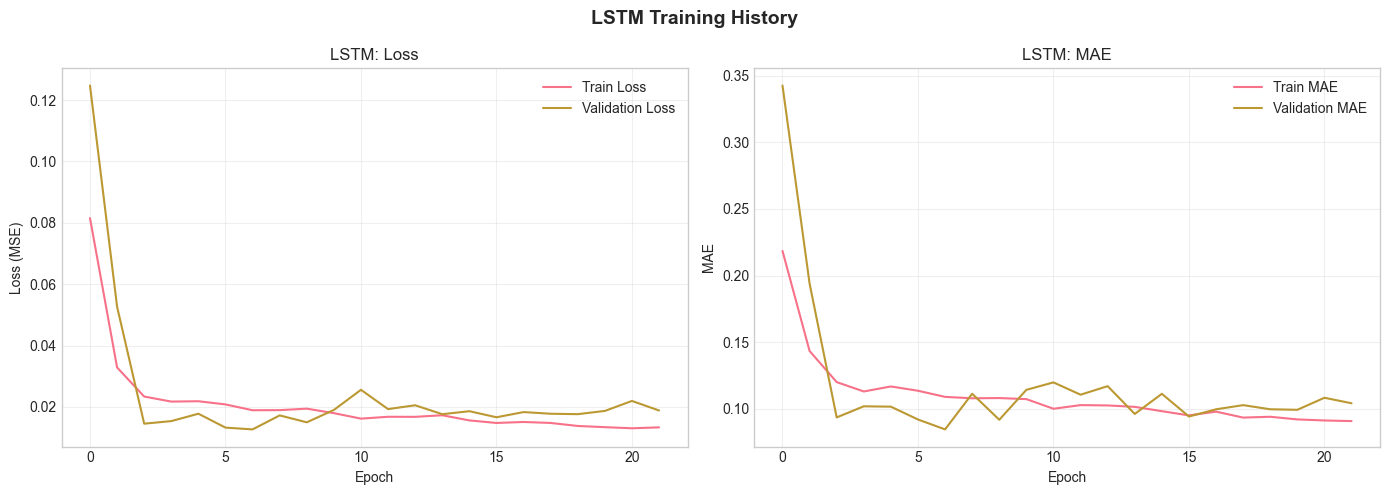

In [22]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_lstm.history['loss'], label='Train Loss')
axes[0].plot(history_lstm.history['val_loss'], label='Validation Loss')
axes[0].set_title('LSTM: Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_lstm.history['mae'], label='Train MAE')
axes[1].plot(history_lstm.history['val_mae'], label='Validation MAE')
axes[1].set_title('LSTM: MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('LSTM Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.2 CNN-LSTM Model

In [23]:
# Build and train CNN-LSTM
cnn_lstm_model = build_cnn_lstm_model(SEQUENCE_LENGTH, n_features)
cnn_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 12, 64)              │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 6, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,721 (135.63 KB)

 Trainable params: 34,529 (134.88 KB)

 Non-trainable params: 192 (768.00 B)

In [24]:
# Train CNN-LSTM
history_cnn_lstm = cnn_lstm_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0888 - mae: 0.2287 - val_loss: 0.3690 - val_mae: 0.5924 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0403 - mae: 0.1588 - val_loss: 0.3868 - val_mae: 0.6076 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0323 - mae: 0.1404 - val_loss: 0.4311 - val_mae: 0.6439 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0257 - mae: 0.1268 - val_loss: 0.4370 - val_mae: 0.6488 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219 - mae: 0.1178 - val_loss: 0.4506 - val_mae: 0.6593 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0234 - mae: 0.1193 - val_loss: 0.4532 - val_mae: 0.6608 - learning_rate: 5.0000e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0231 - mae: 0.1153 - val_loss: 0.4519 - val_mae: 0.6592 - learning_rate: 5.0000e-0

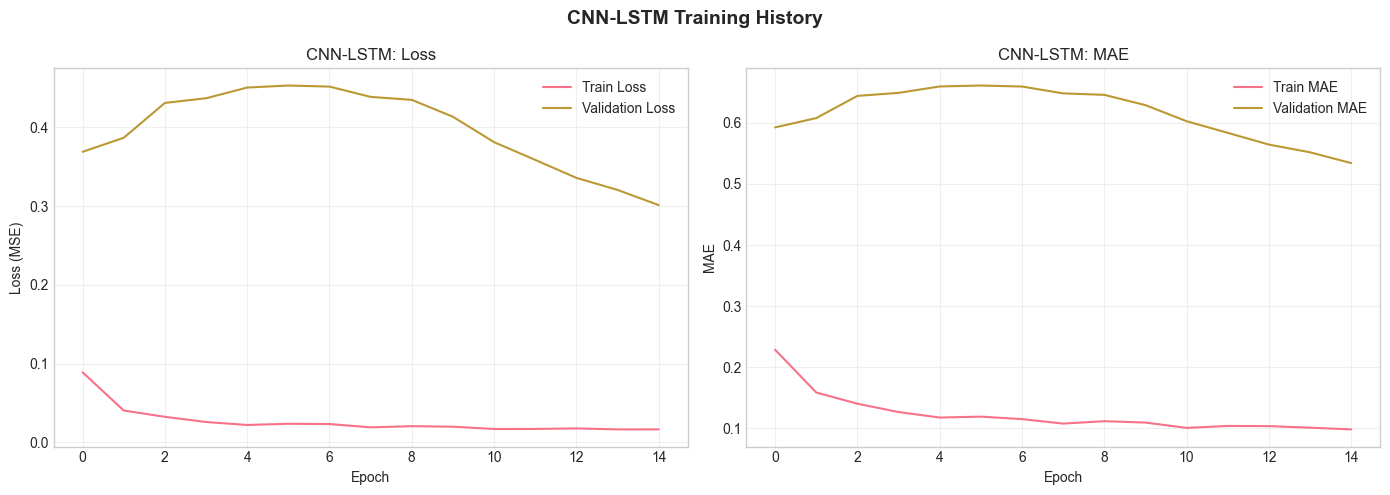

In [25]:
# Plot CNN-LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_cnn_lstm.history['loss'], label='Train Loss')
axes[0].plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
axes[0].set_title('CNN-LSTM: Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_cnn_lstm.history['mae'], label='Train MAE')
axes[1].plot(history_cnn_lstm.history['val_mae'], label='Validation MAE')
axes[1].set_title('CNN-LSTM: MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('CNN-LSTM Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.3 Transformer Model

In [26]:
# Build and train Transformer
transformer_model = build_transformer_model(SEQUENCE_LENGTH, n_features)
transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 12, 6)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12, 64)              │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add (Add)                            │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 12, 64)              │          83,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 12, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,961 (660.00 KB)

 Trainable params: 168,961 (660.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train Transformer
history_transformer = transformer_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.1418 - mae: 0.2891 - val_loss: 0.0269 - val_mae: 0.1329 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0444 - mae: 0.1675 - val_loss: 0.0218 - val_mae: 0.1139 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0343 - mae: 0.1491 - val_loss: 0.0376 - val_mae: 0.1507 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0332 - mae: 0.1457 - val_loss: 0.0237 - val_mae: 0.1225 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0323 - mae: 0.1438 - val_loss: 0.0393 - val_mae: 0.1636 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0292 - mae: 0.1372 - val_loss: 0.0313 - val_mae: 0.1430 - learning_rate: 5.0000e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0285 - mae: 0.1349 - val_loss: 0.0245 - val_mae: 0.1239 - learning_rate: 5.0000e-0

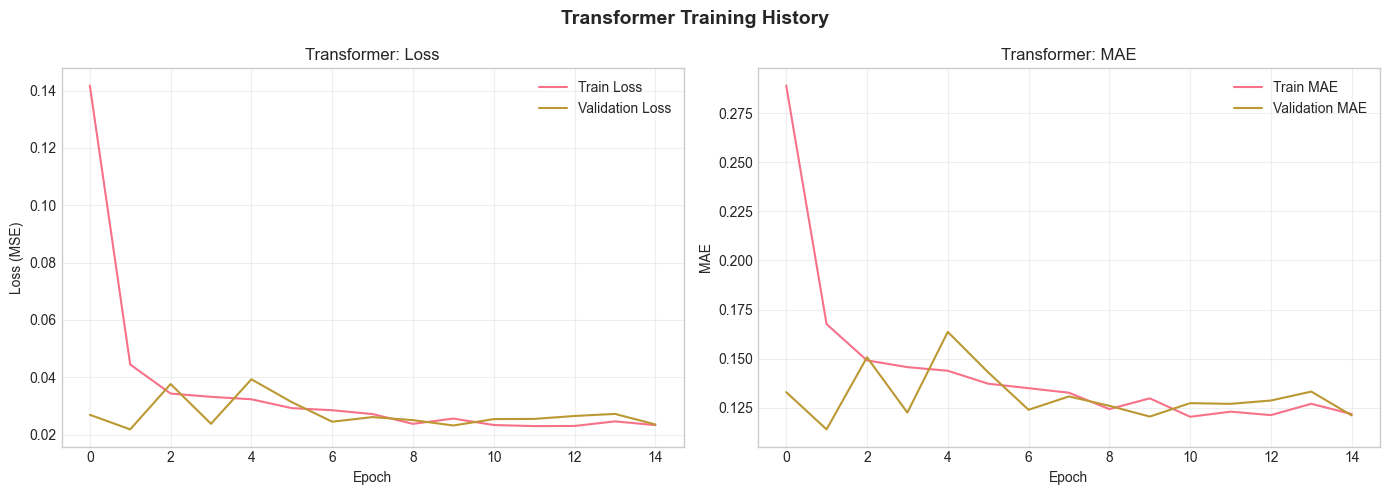

In [28]:
# Plot Transformer training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_transformer.history['loss'], label='Train Loss')
axes[0].plot(history_transformer.history['val_loss'], label='Validation Loss')
axes[0].set_title('Transformer: Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_transformer.history['mae'], label='Train MAE')
axes[1].plot(history_transformer.history['val_mae'], label='Validation MAE')
axes[1].set_title('Transformer: MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Transformer Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Оценка моделей

In [29]:
# Предсказания на тестовом наборе
y_pred_lstm = lstm_model.predict(X_test)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)
y_pred_transformer = transformer_model.predict(X_test)

# Обратное преобразование к исходному масштабу
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_lstm_original = scaler_y.inverse_transform(y_pred_lstm).flatten()
y_pred_cnn_lstm_original = scaler_y.inverse_transform(y_pred_cnn_lstm).flatten()
y_pred_transformer_original = scaler_y.inverse_transform(y_pred_transformer).flatten()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [30]:
# Функция для расчета метрик
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Расчет метрик для всех моделей
metrics = {}

metrics['LSTM'] = calculate_metrics(y_test_original, y_pred_lstm_original)
metrics['CNN-LSTM'] = calculate_metrics(y_test_original, y_pred_cnn_lstm_original)
metrics['Transformer'] = calculate_metrics(y_test_original, y_pred_transformer_original)

# Вывод результатов
print("Результаты оценки моделей:")
print("=" * 50)
print(f"{'Model':<15} {'MAE':<15} {'RMSE':<15}")
print("-" * 50)
for model_name, (mae, rmse) in metrics.items():
    print(f"{model_name:<15} {mae:<15.4f} {rmse:<15.4f}")

Результаты оценки моделей:
Model           MAE             RMSE           
--------------------------------------------------
LSTM            27.3410         27.5692        
CNN-LSTM        8.4640          9.6616         
Transformer     21.4480         22.0274        


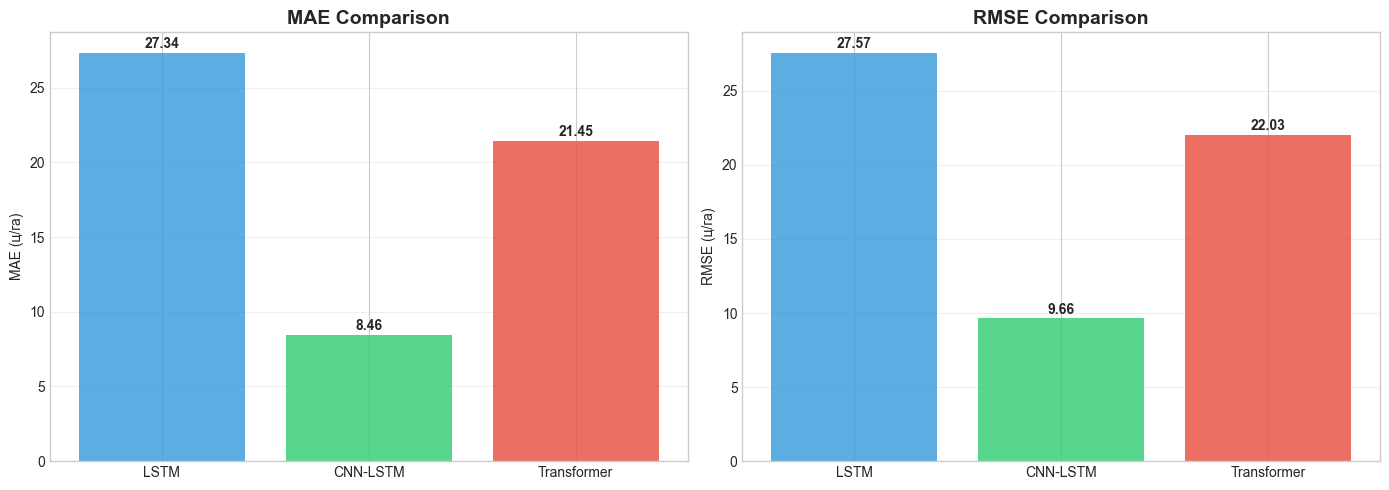

In [31]:
# Визуализация сравнения метрик
models = list(metrics.keys())
mae_values = [metrics[m][0] for m in models]
rmse_values = [metrics[m][1] for m in models]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE comparison
bars1 = axes[0].bar(models, mae_values, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.8)
axes[0].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAE (ц/га)')
axes[0].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, mae_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# RMSE comparison
bars2 = axes[1].bar(models, rmse_values, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.8)
axes[1].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE (ц/га)')
axes[1].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, rmse_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Визуализация прогнозов по регионам

In [32]:
# Функция для получения предсказаний с привязкой к регионам
def get_predictions_by_region(df, X_seq, y_pred, sequence_length=12):
    """
    Привязка предсказаний к регионам
    """
    # Создаем DataFrame для предсказаний
    pred_df = df.iloc[sequence_length:].copy().reset_index(drop=True)
    pred_df = pred_df.iloc[:len(y_pred)].copy()
    pred_df['predicted_yield'] = y_pred
    return pred_df

# Получаем предсказания для лучшей модели (выбираем по минимальному MAE)
best_model_name = min(metrics, key=lambda x: metrics[x][0])
print(f"Лучшая модель: {best_model_name}")

if best_model_name == 'LSTM':
    best_predictions = y_pred_lstm_original
elif best_model_name == 'CNN-LSTM':
    best_predictions = y_pred_cnn_lstm_original
else:
    best_predictions = y_pred_transformer_original

# Получаем тестовые данные с регионами
test_df = df.iloc[SEQUENCE_LENGTH:].copy().reset_index(drop=True)
test_indices = range(len(X_train), len(X_train) + len(X_test))
test_df = test_df.iloc[test_indices].copy()
test_df = test_df.iloc[:len(y_test_original)].copy()
test_df['actual_yield'] = y_test_original
test_df['predicted_yield'] = best_predictions

Лучшая модель: CNN-LSTM


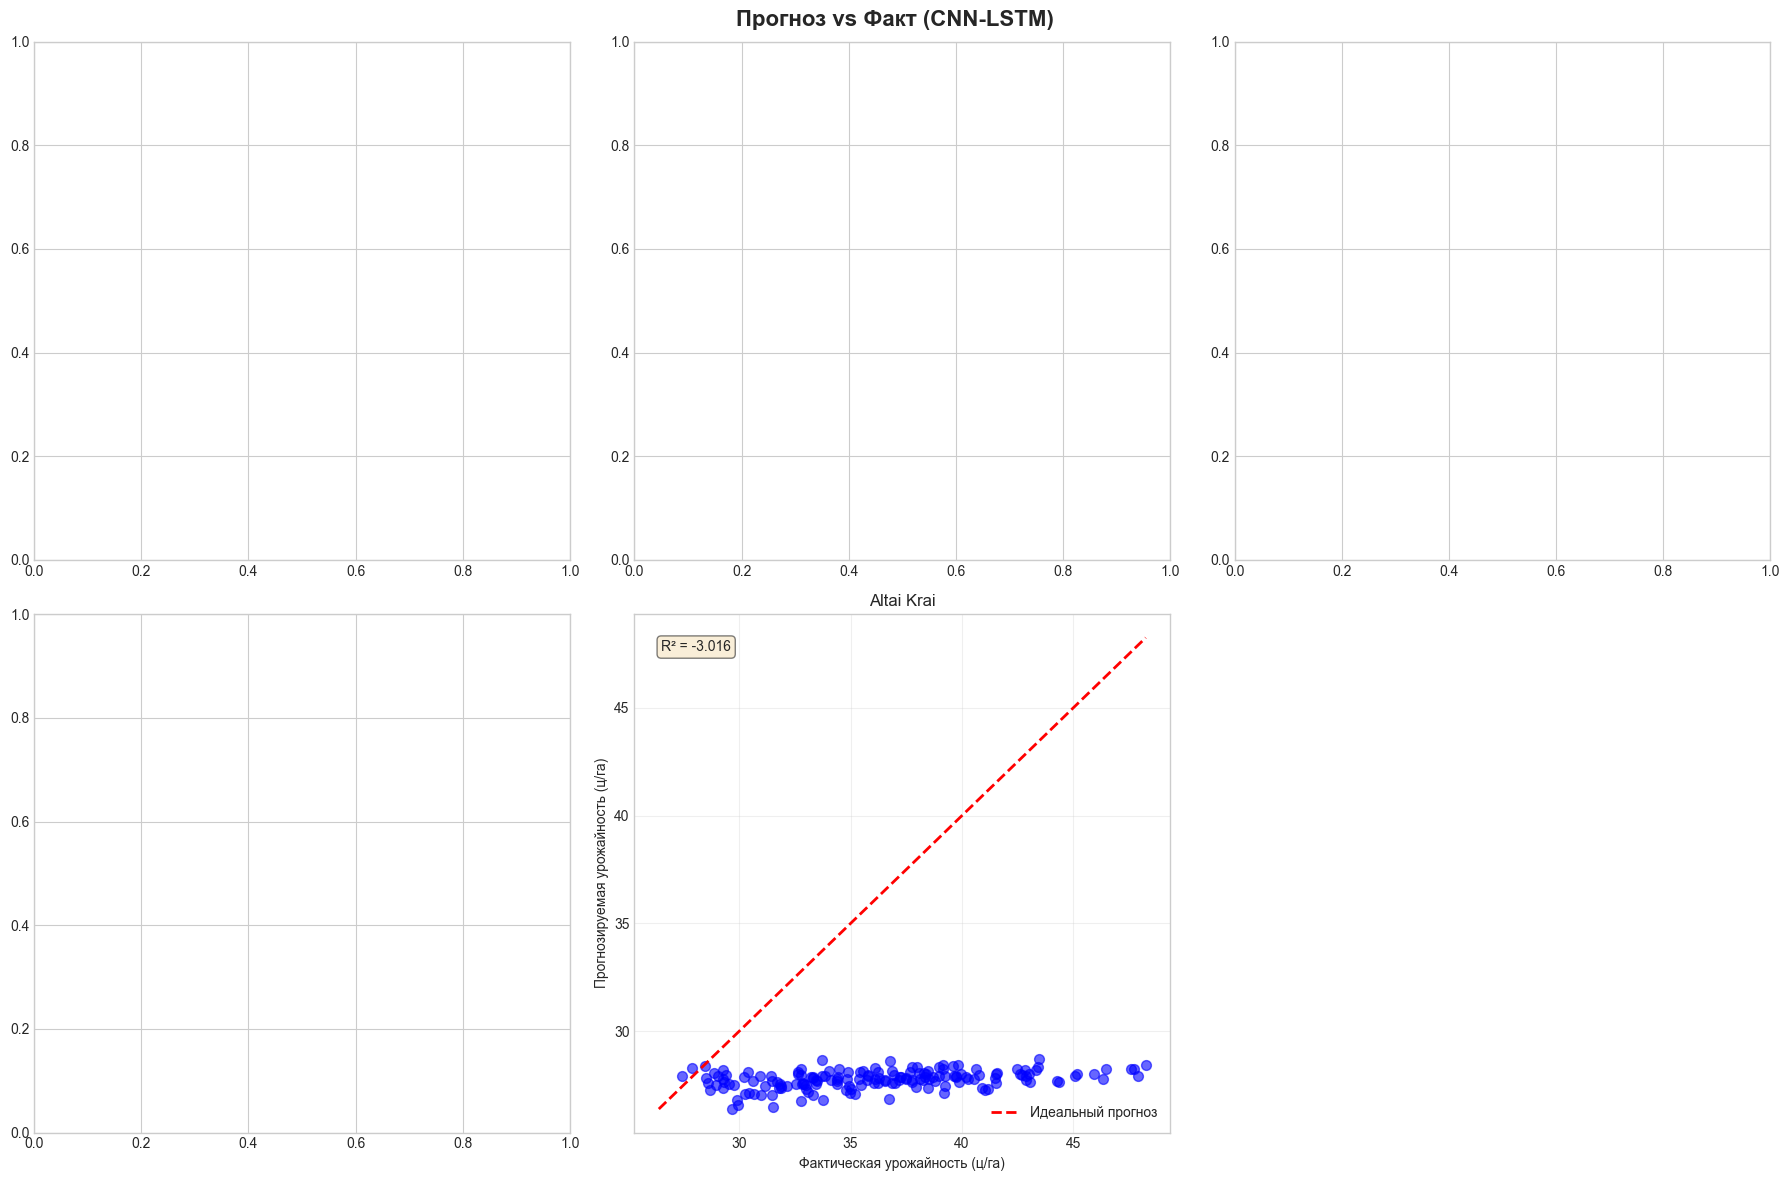

In [34]:
# Визуализация прогнозов по регионам
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, region in enumerate(regions):
    region_data = test_df[test_df['region'] == region]
    
    if len(region_data) > 0:
        axes[i].scatter(region_data['actual_yield'], region_data['predicted_yield'], 
                       alpha=0.6, s=50, color='blue')
        
        # Линия идеального прогноза
        min_val = min(region_data['actual_yield'].min(), region_data['predicted_yield'].min())
        max_val = max(region_data['actual_yield'].max(), region_data['predicted_yield'].max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальный прогноз')
        
        axes[i].set_xlabel('Фактическая урожайность (ц/га)')
        axes[i].set_ylabel('Прогнозируемая урожайность (ц/га)')
        axes[i].set_title(f'{region}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Добавляем R²
        from sklearn.metrics import r2_score
        r2 = r2_score(region_data['actual_yield'], region_data['predicted_yield'])
        axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Удаляем лишний subplot
axes[-1].remove()

plt.suptitle(f'Прогноз vs Факт ({best_model_name})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

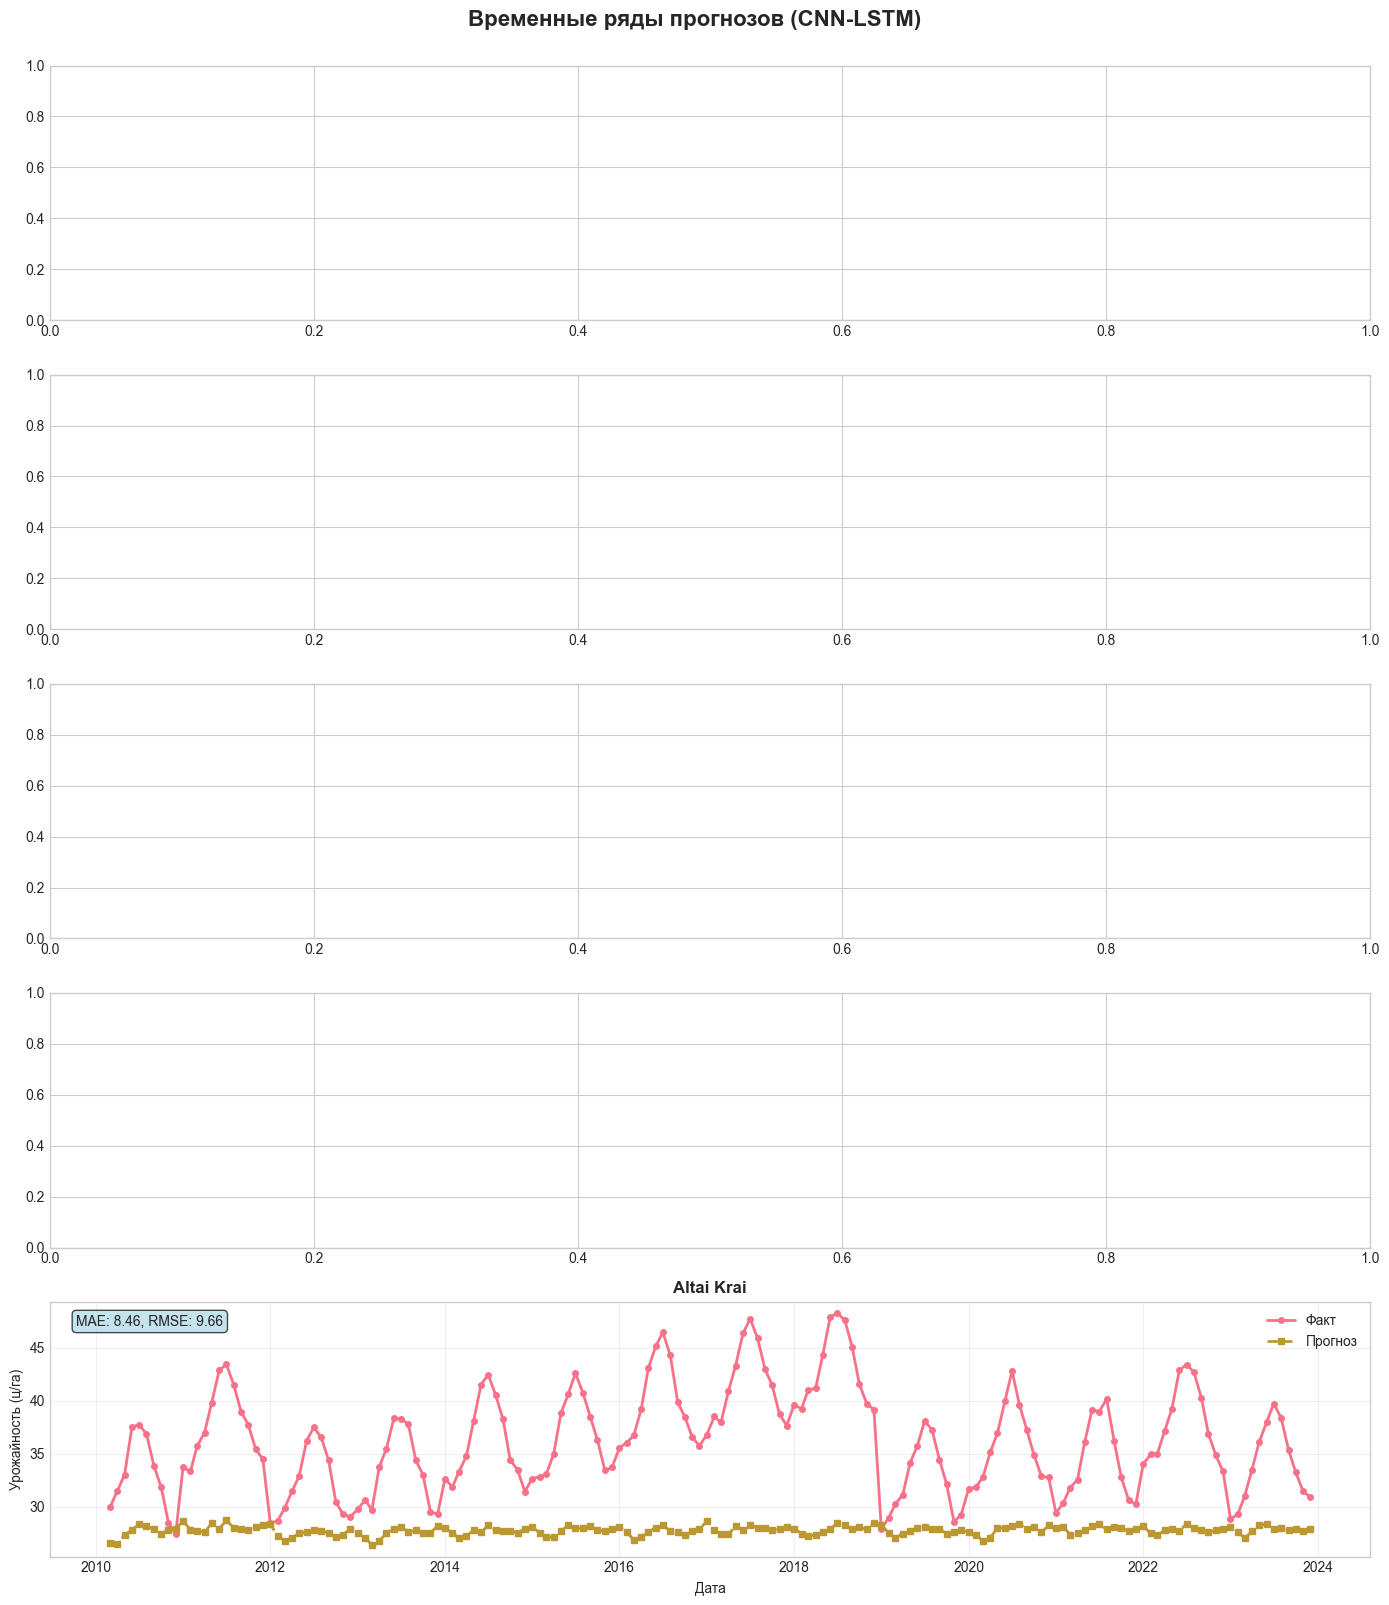

In [35]:
# Временной ряд прогнозов по регионам
fig, axes = plt.subplots(len(regions), 1, figsize=(14, 16))

for i, region in enumerate(regions):
    region_data = test_df[test_df['region'] == region].copy()
    
    if len(region_data) > 0:
        region_data['date'] = pd.to_datetime(region_data[['year', 'month']].assign(day=1))
        region_data = region_data.sort_values('date')
        
        axes[i].plot(region_data['date'], region_data['actual_yield'], 
                    'o-', label='Факт', linewidth=2, markersize=4)
        axes[i].plot(region_data['date'], region_data['predicted_yield'], 
                    's--', label='Прогноз', linewidth=2, markersize=4)
        
        axes[i].set_title(f'{region}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Урожайность (ц/га)')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Рассчитываем ошибку для региона
        mae_region = mean_absolute_error(region_data['actual_yield'], region_data['predicted_yield'])
        rmse_region = np.sqrt(mean_squared_error(region_data['actual_yield'], region_data['predicted_yield']))
        axes[i].text(0.02, 0.95, f'MAE: {mae_region:.2f}, RMSE: {rmse_region:.2f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

axes[-1].set_xlabel('Дата')
plt.suptitle(f'Временные ряды прогнозов ({best_model_name})', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

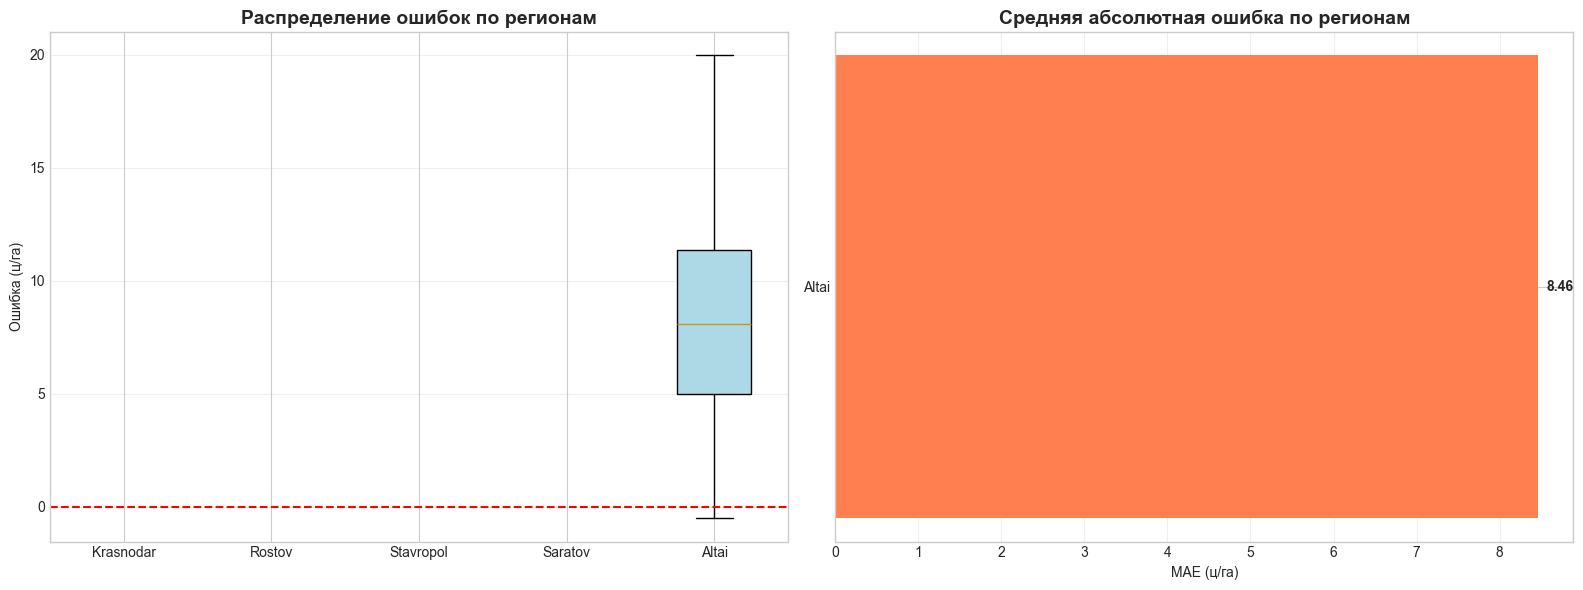

In [36]:
# Распределение ошибок по регионам
test_df['error'] = test_df['actual_yield'] - test_df['predicted_yield']
test_df['abs_error'] = np.abs(test_df['error'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot ошибок по регионам
error_by_region = [test_df[test_df['region'] == r]['error'].values for r in regions]
bp = axes[0].boxplot(error_by_region, labels=[r.split()[0] for r in regions], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_title('Распределение ошибок по регионам', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Ошибка (ц/га)')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=0, color='r', linestyle='--')

# Средняя абсолютная ошибка по регионам
mae_by_region = test_df.groupby('region')['abs_error'].mean().sort_values()
bars = axes[1].barh(range(len(mae_by_region)), mae_by_region.values, color='coral')
axes[1].set_yticks(range(len(mae_by_region)))
axes[1].set_yticklabels([r.split()[0] for r in mae_by_region.index])
axes[1].set_xlabel('MAE (ц/га)')
axes[1].set_title('Средняя абсолютная ошибка по регионам', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
for i, (bar, val) in enumerate(zip(bars, mae_by_region.values)):
    axes[1].text(val + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{val:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Сравнение всех моделей по регионам

In [37]:
# Создаем DataFrame с предсказаниями всех моделей
comparison_df = test_df[['region', 'year', 'month', 'actual_yield']].copy()
comparison_df['LSTM'] = y_pred_lstm_original[:len(comparison_df)]
comparison_df['CNN-LSTM'] = y_pred_cnn_lstm_original[:len(comparison_df)]
comparison_df['Transformer'] = y_pred_transformer_original[:len(comparison_df)]

# Рассчитываем MAE по регионам для каждой модели
region_metrics = []
for region in regions:
    region_data = comparison_df[comparison_df['region'] == region]
    if len(region_data) > 0:
        for model_name in ['LSTM', 'CNN-LSTM', 'Transformer']:
            mae = mean_absolute_error(region_data['actual_yield'], region_data[model_name])
            rmse = np.sqrt(mean_squared_error(region_data['actual_yield'], region_data[model_name]))
            region_metrics.append({
                'region': region,
                'model': model_name,
                'MAE': mae,
                'RMSE': rmse
            })

region_metrics_df = pd.DataFrame(region_metrics)
print("Метрики по регионам:")
region_metrics_df.pivot(index='region', columns='model', values='MAE').round(2)

Метрики по регионам:


model,CNN-LSTM,LSTM,Transformer
region,,,
Altai Krai,8.46,27.34,21.45


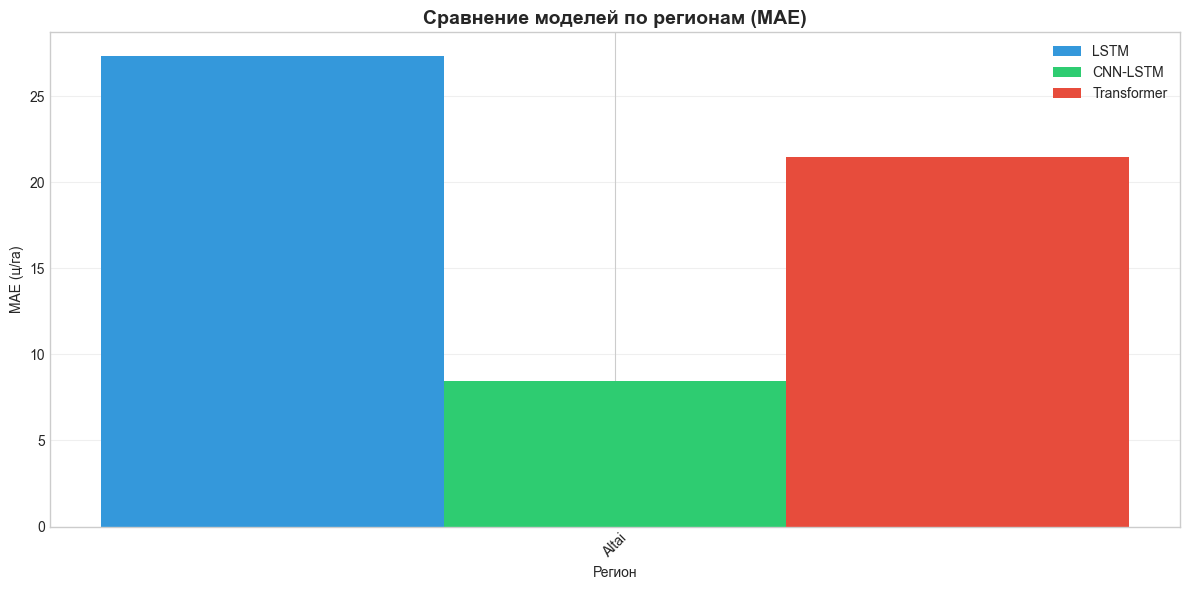

In [38]:
# Визуализация сравнения моделей по регионам
pivot_mae = region_metrics_df.pivot(index='region', columns='model', values='MAE')

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(pivot_mae.index))
width = 0.25

bars1 = ax.bar(x - width, pivot_mae['LSTM'], width, label='LSTM', color='#3498db')
bars2 = ax.bar(x, pivot_mae['CNN-LSTM'], width, label='CNN-LSTM', color='#2ecc71')
bars3 = ax.bar(x + width, pivot_mae['Transformer'], width, label='Transformer', color='#e74c3c')

ax.set_xlabel('Регион')
ax.set_ylabel('MAE (ц/га)')
ax.set_title('Сравнение моделей по регионам (MAE)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([r.split()[0] for r in pivot_mae.index], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Сохранение моделей

In [39]:
import os

# Создаем директорию для моделей
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Сохраняем модели
lstm_model.save(f'{models_dir}/lstm_model.h5')
cnn_lstm_model.save(f'{models_dir}/cnn_lstm_model.h5')
transformer_model.save(f'{models_dir}/transformer_model.h5')

print("Модели сохранены:")
print(f"- {models_dir}/lstm_model.h5")
print(f"- {models_dir}/cnn_lstm_model.h5")
print(f"- {models_dir}/transformer_model.h5")

Модели сохранены:
- ../models/lstm_model.h5
- ../models/cnn_lstm_model.h5
- ../models/transformer_model.h5


In [40]:
# Сохранение скейлеров
import joblib

joblib.dump(scaler_X, f'{models_dir}/scaler_X.pkl')
joblib.dump(scaler_y, f'{models_dir}/scaler_y.pkl')

print("Скейлеры сохранены:")
print(f"- {models_dir}/scaler_X.pkl")
print(f"- {models_dir}/scaler_y.pkl")

Скейлеры сохранены:
- ../models/scaler_X.pkl
- ../models/scaler_y.pkl


## 11. Выводы

In [41]:
# Итоговая сводка
print("=" * 60)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("=" * 60)
print(f"\nЛучшая модель: {best_model_name}")
print(f"MAE: {metrics[best_model_name][0]:.4f} ц/га")
print(f"RMSE: {metrics[best_model_name][1]:.4f} ц/га")

print("\n" + "-" * 60)
print("Сравнение всех моделей:")
print("-" * 60)
for model_name, (mae, rmse) in metrics.items():
    print(f"{model_name:<15} MAE: {mae:.4f} ц/га, RMSE: {rmse:.4f} ц/га")

print("\n" + "=" * 60)
print("ОСОБЕННОСТИ ДАННЫХ:")
print("=" * 60)
print(f"• Регионы: {', '.join(regions)}")
print(f"• Период: {df['year'].min()}-{df['year'].max()}")
print(f"• Признаки: NDVI, EVI, температура, осадки, солнечная радиация")
print(f"• Целевая переменная: урожайность зерновых (ц/га)")

print("\n" + "=" * 60)
print("РЕКОМЕНДАЦИИ:")
print("=" * 60)
print("• Для улучшения точности можно добавить больше метеорологических признаков")
print("• Использовать более длинные временные последовательности")
print("• Применить ансамблирование моделей")
print("• Добавить данные о типах почв и сельскохозяйственных практиках")

ИТОГОВЫЕ РЕЗУЛЬТАТЫ

Лучшая модель: CNN-LSTM
MAE: 8.4640 ц/га
RMSE: 9.6616 ц/га

------------------------------------------------------------
Сравнение всех моделей:
------------------------------------------------------------
LSTM            MAE: 27.3410 ц/га, RMSE: 27.5692 ц/га
CNN-LSTM        MAE: 8.4640 ц/га, RMSE: 9.6616 ц/га
Transformer     MAE: 21.4480 ц/га, RMSE: 22.0274 ц/га

ОСОБЕННОСТИ ДАННЫХ:
• Регионы: Krasnodar Krai, Rostov Oblast, Stavropol Krai, Saratov Oblast, Altai Krai
• Период: 2010-2023
• Признаки: NDVI, EVI, температура, осадки, солнечная радиация
• Целевая переменная: урожайность зерновых (ц/га)

РЕКОМЕНДАЦИИ:
• Для улучшения точности можно добавить больше метеорологических признаков
• Использовать более длинные временные последовательности
• Применить ансамблирование моделей
• Добавить данные о типах почв и сельскохозяйственных практиках
